## Grid search for tuning hyperparameters

In [108]:
# Imports
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy.io import arff
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time

In [121]:
# Define problem params
N_max = 5000 # number of max input instances
max_neighbors = 200 # number of maximum neighbors for nearest neighbor models

In [122]:
# Import dataset
data = arff.loadarff("ALOI_withoutdupl.arff") # unnormalized
df = pd.DataFrame(data[0])
df.outlier = df.outlier.str.decode("utf-8")
df['outlier'] = df['outlier'].map({'yes':1,'no':0}) # convert yes/no to 1/0
df.dropna()
if 'id' in df:
    del df['id'] # drop id column
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att19,att20,att21,att22,att23,att24,att25,att26,att27,outlier
0,0.872812,0.000005,0.0,0.000036,0.0,0.0,0.0,0.0,0.0,0.050327,...,0.014212,0.000104,0.0,0.025490,0.004937,0.000011,0.000054,0.006804,0.015385,1
1,0.975206,0.000000,0.0,0.000651,0.0,0.0,0.0,0.0,0.0,0.007039,...,0.000000,0.000000,0.0,0.004853,0.001582,0.000000,0.000000,0.000201,0.000000,1
2,0.963777,0.000000,0.0,0.002005,0.0,0.0,0.0,0.0,0.0,0.006642,...,0.000000,0.000000,0.0,0.007828,0.002523,0.000000,0.000393,0.003800,0.000000,1
3,0.973246,0.000000,0.0,0.000556,0.0,0.0,0.0,0.0,0.0,0.008979,...,0.000000,0.000000,0.0,0.004392,0.000170,0.000000,0.000000,0.000007,0.000000,1
4,0.960720,0.000000,0.0,0.000656,0.0,0.0,0.0,0.0,0.0,0.013319,...,0.000000,0.000000,0.0,0.010299,0.000561,0.000000,0.000084,0.000264,0.000000,1


In [123]:
# Subsample if N > N_max
if(len(df) > N_max):
        df = df.sample(n=N_max)
print("Size of sampled dataset:",len(df))

Size of sampled dataset: 5000


In [124]:
# Split (stratified) train and test sets
X  = df.iloc[:, :-1] # drop labels for X
y = df['outlier'] # keep labels for y
# Random state set for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y) # stratified split
print("Ratio of outliers in training set:", len(y_train[y_train==1])/len(y_train))
print("Ratio of outliers in test set:", len(y_test[y_test==1])/len(y_test))
print("Training size:", len(X_train))
print("Test size:", len(X_test))

Ratio of outliers in training set: 0.029
Ratio of outliers in test set: 0.029
Training size: 4000
Test size: 1000


In [125]:
# Normalize training set
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
for col in X_train_norm.columns:
    mu = X_train_norm[col].mean()
    sig = X_train_norm[col].std()
    X_train_norm[col] = (X_train_norm[col] - mu) / sig
    X_test_norm[col] = (X_test_norm[col] - mu) / sig

In [126]:
# Show unnormalized training set
X_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att18,att19,att20,att21,att22,att23,att24,att25,att26,att27
5392,0.957214,0.000038,0.000000,0.001539,0.000106,0.000000,0.000000,0.0,0.000000,0.001890,...,0.000086,0.000002,0.000000,0.0,0.000009,0.006499,0.000063,0.000000,0.001252,0.001429
29641,0.877525,0.002970,0.000005,0.000328,0.004397,0.000104,0.000000,0.0,0.000002,0.015883,...,0.009467,0.005902,0.000016,0.0,0.035043,0.003902,0.000434,0.000000,0.000346,0.011852
40698,0.709739,0.000011,0.000000,0.000113,0.000002,0.000000,0.000000,0.0,0.000000,0.009691,...,0.000000,0.000000,0.000002,0.0,0.000014,0.024378,0.000203,0.000002,0.031630,0.148844
13438,0.789151,0.000005,0.000000,0.000588,0.000009,0.000000,0.000000,0.0,0.000000,0.006940,...,0.000000,0.000278,0.000000,0.0,0.001008,0.022590,0.000009,0.000249,0.097080,0.020214
23385,0.881675,0.000045,0.000000,0.002713,0.000005,0.000000,0.000002,0.0,0.000000,0.010733,...,0.000016,0.023456,0.000120,0.0,0.045824,0.004659,0.000122,0.000864,0.005674,0.015200


In [127]:
# Show normalized training set
X_train_norm.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att18,att19,att20,att21,att22,att23,att24,att25,att26,att27
5392,0.726420,-0.235688,-0.077320,-0.074995,-0.216955,-0.153753,-0.083646,-0.092729,-0.083001,-0.653079,...,-0.169345,-0.292633,-0.096957,-0.112415,-0.458084,0.276993,-0.091031,-0.327323,-0.464419,-0.441333
29641,-0.264230,-0.017078,-0.075452,-0.186428,0.423881,-0.117648,-0.083646,-0.092729,-0.081693,-0.143180,...,2.029378,0.006449,-0.085002,-0.112415,1.321305,-0.019078,0.523571,-0.327323,-0.516758,-0.110757
40698,-2.350043,-0.237710,-0.077320,-0.206178,-0.232486,-0.153753,-0.083646,-0.092729,-0.083001,-0.368804,...,-0.189478,-0.292748,-0.095249,-0.112415,-0.457854,2.314958,0.141318,-0.327192,1.289509,4.233909
13438,-1.362849,-0.238216,-0.077320,-0.162520,-0.231473,-0.153753,-0.083646,-0.092729,-0.083001,-0.469054,...,-0.189478,-0.278653,-0.096957,-0.112415,-0.407336,2.111136,-0.180973,-0.312878,5.068456,0.154436
23385,-0.212635,-0.235182,-0.077320,0.032905,-0.232148,-0.153753,-0.074607,-0.092729,-0.083001,-0.330829,...,-0.185769,0.896247,-0.006438,-0.112415,1.868853,0.067244,0.006406,-0.277159,-0.209122,-0.004580


In [128]:
# Initialize metrics arrays
TP_scores = []
TN_scores = []
FP_scores = []
FN_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
f1_scores = []
auc_scores = []
train_times = []
pred_times = []
# Loop over all possible hyperparam values (max neighbors)
for i in range(1, max_neighbors):
    clf = KNN(n_neighbors=i)
    t0 = time.time() 
    clf.fit(X_train_norm) # training
    t1 = time.time()
    train_times.append(t1-t0)
    # Compute and store performance metrics
    t2 = time.time()
    y_pred = clf.predict(X_test_norm) # prediction
    t3 = time.time()
    pred_times.append(t3-t2)
    C = confusion_matrix(y_test, y_pred) # confusion matrix
    TP_scores.append(C[1,1]) # tp
    TN_scores.append(C[0,0]) # tn
    FP_scores.append(C[0,1]) # fp
    FN_scores.append(C[1,0]) # fn
    precision_scores.append(precision_score(y_test,y_pred)) # precision
    recall_scores.append(recall_score(y_test,y_pred)) # recall
    accuracy_scores.append(accuracy_score(y_test, y_pred)) # accuracy
    f1_scores.append(f1_score(y_test, y_pred)) # f1
    y_test_scores = clf.decision_function(X_test) # decision_function()
    auc_scores.append(roc_auc_score(y_test, y_test_scores)) # auc

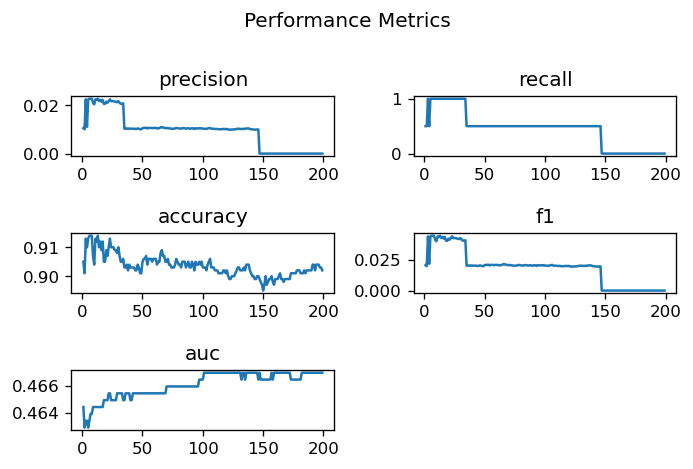

In [117]:
# Plot performance metrics in hyperparam space
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, dpi=120)
fig.suptitle("Performance Metrics", fontsize=12)
x=range(1,max_neighbors)
ax1.plot(x, precision_scores)
ax1.set_title("precision")
ax2.plot(x, recall_scores)
ax2.set_title("recall")
ax3.plot(x, accuracy_scores)
ax3.set_title("accuracy")
ax4.plot(x, f1_scores)
ax4.set_title("f1")
ax5.plot(x, auc_scores)
ax5.set_title("auc")
ax6.set_visible(False) # hide
fig.tight_layout(pad=1.5) # space between plots

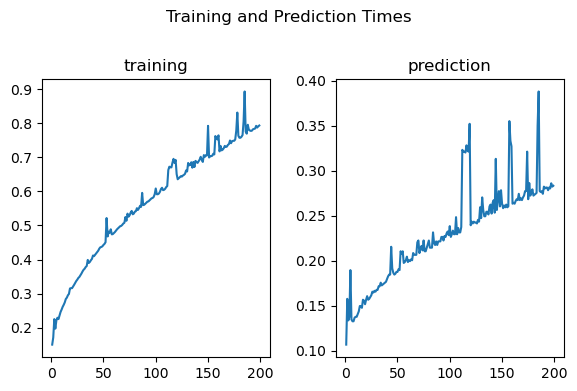

In [118]:
# Plot training and prediction times
fig, ((ax1, ax2)) = plt.subplots(1, 2, dpi=100)
fig.suptitle("Training and Prediction Times", fontsize=12)
x=range(1,max_neighbors)
ax1.plot(x, train_times)
ax1.set_title("training")
ax2.plot(x, pred_times)
ax2.set_title("prediction")
fig.tight_layout(pad=1.5) # space between plots

In [119]:
# Total time for training
sum(train_times)

113.24829959869385

In [120]:
# Total time for prediction
sum(pred_times)

45.7660174369812